In [2]:
import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
con = sqlite3.connect('../data/CD/Nilerat_lipids_CD33_aligned.cdResult')
cur = con.cursor()

## Define short table names

In [4]:
cmpd = 'ConsolidatedUnknownCompoundItems'
# cur.description to get column names
cmpd_cols = ['ID',
 'Name',
 'MolecularWeight',
 'RetentionTime',
 'MaxArea',
 'NumberOfAdducts',
 'MSnStatus',
 'MSDepth',
 'ExcludedBy',
 'Tags',
 'Checked',
 'Area',
 'ReferenceIon',
 'MassOverCharge',
 'PQFFWHM2Base',
 'PQFJaggedness',
 'PQFModality',
 'PQFZigZagIndex',
 'PeakRating',
 'GapStatus',
 'BackupGapStatus',
 'GapFillStatus',
 'BackgroundStatus',
 'mzCloudBestMatch',
 'NumberOfmzCloudResults',
 'NumberOfScanIDsmzCloud',
 'mzCloudLibraryMatches',
 'mzCloudBestMatchConfidence',
 'NumberOfSpectrawithMSnn2Hit',
 'mzCloudBestTreeMatch',
 'mzCloudBestSimMatch',
 'NumberOfChemSpiderResults',
 'NumberOfMetabolikaPathways',
 'MetabolikaPathways',
 'NumberOfSimilarityResults',
 'ElementalCompositionFormula',
 'ElementalCompositionFormulaOriginal',
 'MolStructure',
 'FIShCoverage',
 'AnnotationMolecularWeight',
 'AnnotationDeltaMassInDa',
 'AnnotationDeltaMassInPPM',
 'AnnotationMatchStatus']
# cpf
# feat

## Parse Area column in compounds table
### Area is a blob of binary

- Blob is 603 bytes, with 67 files that gives 9 bytes per area value
- 8 bytes = Double precision float
- 9th byte is \x01 separator
- Therefore extract 0-8, 9-17, 

In [5]:
a = cur.execute(f'SELECT Area FROM {cmpd}').fetchone()[0]
a

b'\x1f\xb6t}\xc2\x1a\xe3@\x013\xef\xd4\x1e\x96\x80\xa2@\x01\xbf\xd6\xd6\xed\x06\x1a\x83A\x01&\xc6O"\x8f`\xb8A\x01\xc29l\xe8E\x97\x9fA\x01\x94\ngD\x0bd\xc1A\x01\xd5\x81\xb9a\xf1H\x96A\x01\xe1X\x16\xaf\xe2\xc0\xbdA\x01x\x92\xb6\x06Nk\x97A\x01\x9c\xb9"a\xfe]\xb2A\x01;]\x903\xb2\x8e\x90A\x01\xf1.\x92T\x07\x11\xa3A\x01\xc1\xd5\xa43]T\x97A\x01\xd4\xaf\\x\xff\xef\xc3A\x01\x84\x8a}\x00C\x99\x92A\x010\xc4\xe0\x1et\r\xb9A\x01O\xb1\x0f\x16\xcb\xa6\xa7A\x01#\x14[$\xb3\xb1\xcbA\x01\x99,p\x9e\xf2I\x86A\x01\xca\xe6A}[\x9e\xb8A\x01n9QF\xf8\xd9\xa6A\x01`\x12\x14\x06y\x1b\xb2A\x01\xc4\xb7&\xf5\xee1\xa7A\x01[\x08\xf4\x9fH\xa8\xbdA\x01\xeea\x87G\x87\x80\xaeA\x01/\xe3\x08\xa9\x81\x9a\xb2A\x01\xae\x7f\xef)\x8a\x90\x9aA\x01\xd1\xd4&\xcc0\xa8\xb2A\x01\x0b\xf1\xad6\rx\xa1A\x01\xaa\x82\xce\xa7\xddg\xabA\x01\xc52\x1a\xb4\xb1\x8d\xa4A\x01M\x7f\xfc\x99Y\xc3\xb0A\x01\xfaVd\xa4\xa5\x13\x9eA\x01k\xee\xcd\x7f\xa0B\xb4A\x01|\x9c\xbb\r\xfdH\xa4A\x01\xef\xc1\'\x7f\xe0\x99\xb8A\x01\xa8)\x08\xfaO\xac\xbdA\x01\xe6\x95\xda\x

In [6]:
# Parse Area column in Compounds table
# With 67 files and 603 byes in the areas, this is 9 bytes per float
print(a[8::9])
# every 9th byte is 0x01 which suggests start byte

b'\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01'


Text(0.5, 1.0, 'Distribution of values looks like peak areas for a feature')

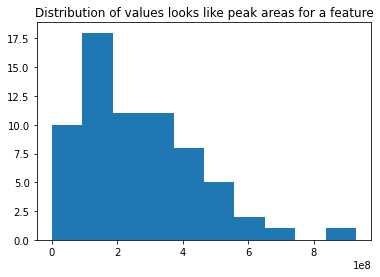

In [7]:
import struct
# https://stackoverflow.com/questions/50107670/python-convert-8-byte-ieee754-number-to-float
l = []
for i in np.arange(0, len(a), 9):
    d = struct.unpack('d', a[i:i+8])[0]
    l.append(d)
#     print(i, d)
plt.hist(l)
plt.title('Distribution of values looks like peak areas for a feature')

### Do the PQF columns follow the same convention as Area (8 bytes, 1 separator byte)?
### What are the unique values in each PQF? 

In [8]:
# Modality, Jaddedness, FWHM2Base, ZigZagIndex
pqf = cur.execute(f'SELECT PQFZigZagIndex FROM {cmpd}').fetchone()[0] 
print(len(pqf))
s = set()
for i in np.arange(0, 603, 9):
    raw = pqf[i: i+8]
    val = struct.unpack('d', raw)[0]
    s.add(val)
    s.add(raw)
# [s.add(x) for x in pqf]
s

603


{0.0,
 0.00014751217291244972,
 0.0002359598334711016,
 0.00029000737197776175,
 0.00030862262190284247,
 0.00046801687285345095,
 0.0007759596915077421,
 0.0008897620506193199,
 0.0011470318790684718,
 0.001160524993541465,
 0.00181411874036842,
 0.0024265340610946638,
 1.3496442183639802e-05,
 2.231382513777258e-05,
 5.2511902581283965e-06,
 9.833605635908679e-05,
 b"\x9f\x0cNt\xdd'M?",
 b'3\xe4L*\xf7\xb8]?',
 b'W\xc6\xbf\xbf8mI?',
 b'\x00\x00\x00\x00\x00\x00\x00\x00',
 b'\x81\x9e\xb2)\x05\xac>?',
 b'\x83\xf7\x95\x958\xc7\x19?',
 b'\xa4"\xaa\xe3\xd8M\xec>',
 b'\xd5\x08\xe7/l\x06\xd6>',
 b'\xd9\xae/c\xd2e\xf7>',
 b'\xdd#\xb6\xea\xafU#?',
 b'\xea[\xa1-\x84\x013?',
 b'\xf3{`\x11\xd494?',
 b'\xf5M.9\x98\x03S?',
 b'f\xcb\x1d\x1a\x00\xcbR?',
 b'p\xdb-\x89\x7f\xed.?',
 b'}\xc7\xeb\x8d\xcf\xe0c?'}

In [9]:
struct.unpack('d', pqf[:8])

(0.0,)

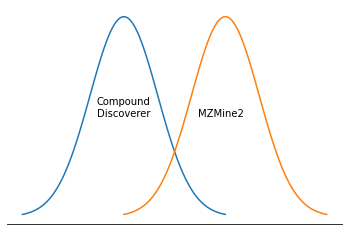

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import seaborn as sns

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y= stats.norm.pdf(x, mu, sigma)
plt.plot(x, y)
plt.plot(x + 3, y)

plt.text(-0.8, 0.2, 'Compound\nDiscoverer')
plt.text(2.2, 0.2, 'MZMine2')

plt.xticks([])
plt.yticks([])
sns.despine(left=True)

plt.savefig('../reports/figures/fig1/CD_mzmine_gaussians.png', bbox_inches='tight', dpi=300)

In [ ]:
plt.plot()